In [1]:
import numpy as np
import h5py

X_train = []
X_valid = []
X_test = []

# 导入数据预处理的特征
model_name = ["gap_pred_resnet50.h5"]
for filename in model_name:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['train_label'])
        y_valid = np.array(h['valid_label'])
    
        
X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid,axis = 1)
X_test = np.concatenate(X_test, axis=1)



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import Model
from keras.layers import Input,Dropout,Dense,Flatten

np.random.seed(2018)

#搭建模型Top层
input_tensor = Input(X_train.shape[1:])
x = Dense(1, activation='sigmoid')(input_tensor)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [4]:
from PIL import Image
from keras.preprocessing import image
from keras.callbacks import Callback,EarlyStopping

#回调函数，获取loss和acc
class LossHistory(Callback):
    def on_train_begin(self,log={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
    def on_epoch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = LossHistory()

#早停机制，监控验证集上的精度Acc
earlystop = EarlyStopping(monitor='val_acc',patience =10,verbose=1,mode = 'max')
#Validation Data
valid_data = (X_valid,y_valid)
#训练模型
model.fit(X_train, y_train, batch_size=128, epochs=50,validation_data=valid_data,callbacks = [history,earlystop])

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 36s 2ms/step - loss: 0.1506 - acc: 0.9461 - val_loss: 0.0804 - val_acc: 0.9716
Epoch 2/50
20000/20000 [==============================] - 1s 27us/step - loss: 0.0701 - acc: 0.9743 - val_loss: 0.0628 - val_acc: 0.9758
Epoch 3/50
20000/20000 [==============================] - 1s 27us/step - loss: 0.0596 - acc: 0.9771 - val_loss: 0.0793 - val_acc: 0.9696
Epoch 4/50
20000/20000 [==============================] - 1s 27us/step - loss: 0.0543 - acc: 0.9791 - val_loss: 0.0584 - val_acc: 0.9768
Epoch 5/50
20000/20000 [==============================] - 1s 27us/step - loss: 0.0514 - acc: 0.9805 - val_loss: 0.0769 - val_acc: 0.9682
Epoch 6/50
20000/20000 [==============================] - 1s 27us/step - loss: 0.0475 - acc: 0.9808 - val_loss: 0.0623 - val_acc: 0.9768
Epoch 7/50
20000/20000 [==============================] - 1s 27us/step - loss: 0.0458 - acc: 0.9820 - val_loss: 0.0542 - val_acc:

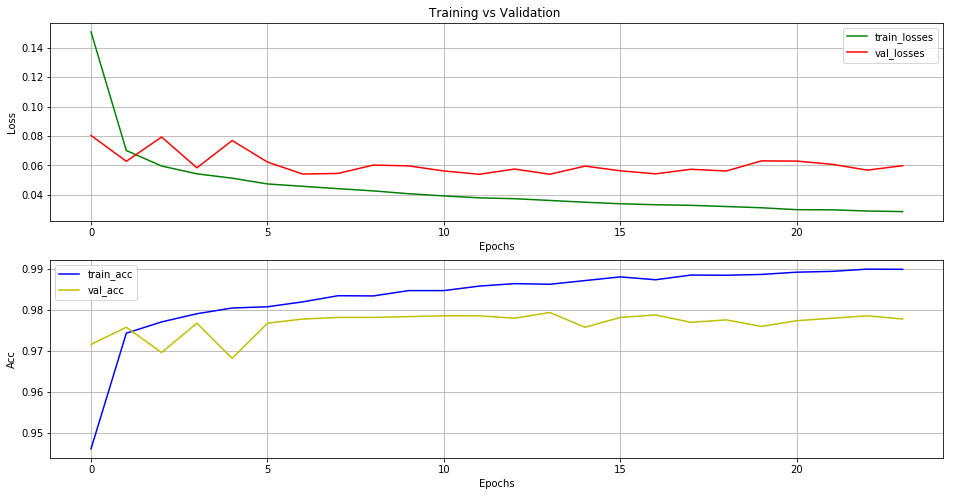

In [5]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

losses,val_losses ,acc,val_acc= history.losses,history.val_losses,history.acc,history.val_acc
fig = plt.figure(figsize = (16,8))

plt.subplot(211) 

plt.plot(losses,'g',label = 'train_losses')
plt.plot(val_losses,'r',label = 'val_losses')
plt.grid(True)
plt.title('Training vs Validation ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.subplot(212) 

plt.plot(acc,'b',label = 'train_acc')
plt.plot(val_acc,'y',label = 'val_acc')
plt.ylabel('Acc')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

In [6]:
import os

#保存模型
if not os.path.exists('models'):
    os.mkdir('models')

model_json_string = model.to_json()
open("./models/model_string_ResNet50.json",'w+').write(model_json_string)
model.save_weights("./models/model_weights_ResNet50.h5")

# Check Point1

In [7]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model,model_from_json
from keras.layers import Dense,Input,GlobalAveragePooling2D,Dropout,Lambda
import numpy as np

import h5py

#导入测试数据
filename = 'gap_pred_resnet50.h5'
with h5py.File(filename, 'r') as h:
    X_test =np.array(h['test'])

#导入模型
model = model_from_json(open("./models/model_string_ResNet50.json",'r').read())
model.load_weights('./models/model_weights_ResNet50.h5')


#模型预测，并对输出预测进行限值
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)


12500/12500 [==============================] - 0s 25us/step


In [8]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

#获取测试集文件的顺序，确保预处理predict和最终模型predict的顺序是一致的
image_size = (224, 224)
image_gen = ImageDataGenerator()
test_gen  = image_gen.flow_from_directory("test_gen",image_size, shuffle=False, batch_size=32, class_mode=None)

#按照Kaggle的格式
pred_filenames = test_gen.filenames
for i, fname in enumerate(pred_filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])


df.to_csv('pred_base_model_ResNet50.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


# Check Point2

In [16]:
import numpy as np
import h5py

X_train = []
X_valid = []
X_test = []

#导入Xception模型的预训练权重
model_name = ["gap_pred_xception.h5"]
for filename in model_name:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['train_label'])
        y_valid = np.array(h['valid_label'])
     
        
X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid,axis = 1)
X_test = np.concatenate(X_test, axis=1)


In [17]:
from keras.models import Model
from keras.layers import Dense ,Dropout,Input

#构建Top_model
input_tensor = Input(X_train.shape[1:])
layer = input_tensor
layer = Dropout(0.5)(layer)
layer = Dense(256,activation = 'relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,activation = 'sigmoid')(layer)

model = Model(input_tensor,layer)

model.compile(optimizer = 'adadelta',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 524,801
Trainable params: 524,801
Non-trainable params: 0
_________________________________________________________________


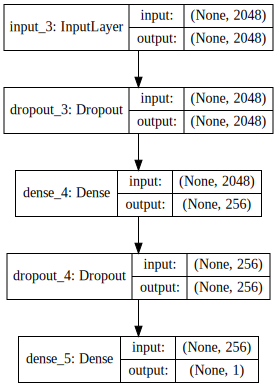

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

In [20]:
from keras.callbacks import Callback,EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self,log={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
    def on_epoch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = LossHistory()

earlystop = EarlyStopping(monitor='val_acc',patience =10,verbose=1,mode = 'max')

valid_data = (X_valid,y_valid)

model.fit(X_train, y_train, batch_size=128, epochs=50,validation_data=valid_data,callbacks = [history,earlystop])

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 1s 45us/step - loss: 0.0503 - acc: 0.9856 - val_loss: 0.0188 - val_acc: 0.9934
Epoch 2/50
20000/20000 [==============================] - 1s 33us/step - loss: 0.0241 - acc: 0.9932 - val_loss: 0.0188 - val_acc: 0.9932
Epoch 3/50
20000/20000 [==============================] - 1s 33us/step - loss: 0.0219 - acc: 0.9937 - val_loss: 0.0172 - val_acc: 0.9942
Epoch 4/50
20000/20000 [==============================] - 1s 33us/step - loss: 0.0193 - acc: 0.9937 - val_loss: 0.0183 - val_acc: 0.9942
Epoch 5/50
20000/20000 [==============================] - 1s 33us/step - loss: 0.0186 - acc: 0.9948 - val_loss: 0.0180 - val_acc: 0.9946
Epoch 6/50
20000/20000 [==============================] - 1s 33us/step - loss: 0.0176 - acc: 0.9948 - val_loss: 0.0263 - val_acc: 0.9924
Epoch 7/50
20000/20000 [==============================] - 1s 33us/step - loss: 0.0172 - acc: 0.9949 - val_loss: 0.0173 - val_acc:

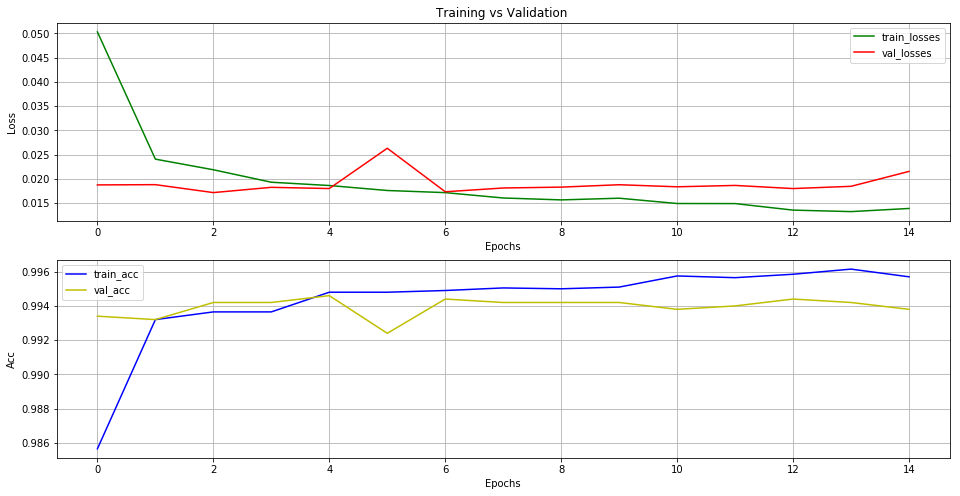

In [21]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

losses,val_losses ,acc,val_acc= history.losses,history.val_losses,history.acc,history.val_acc
fig = plt.figure(figsize = (16,8))

plt.subplot(211) 

plt.plot(losses,'g',label = 'train_losses')
plt.plot(val_losses,'r',label = 'val_losses')
plt.grid(True)
plt.title('Training vs Validation ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc=0)

plt.subplot(212) 

plt.plot(acc,'b',label = 'train_acc')
plt.plot(val_acc,'y',label = 'val_acc')
plt.ylabel('Acc')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(loc=0)

In [22]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

import os

df = pd.read_csv("sample_submission.csv")

image_size = (299, 299)
image_gen = ImageDataGenerator()
test_gen  = image_gen.flow_from_directory("test_gen",image_size, shuffle=False, batch_size=16, class_mode=None)

#y_pred = model.predict_generator(test_gen,verbose = 1)
y_pred = model.predict(X_test,verbose = 1)
y_pred = y_pred.clip(min=0.005, max=0.995)


pred_filenames = test_gen.filenames

#pred_filenames = os.listdir('test_gen/test')

for i, fname in enumerate(pred_filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])


df.to_csv('pred_gap.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.
12500/12500 [==============================] - 0s 36us/step


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


In [23]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

model_json_string = model.to_json()
open("./models/model_string_xception_top.json",'w+').write(model_json_string)
model.save_weights("./models/model_weights_xception_top.h5")

# Check point3

In [24]:
from keras.models import Model,Sequential,model_from_json
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,Input,Lambda
from keras.applications.xception import Xception,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

#Xception模型输入数据预处理
x = Input((299,299,3))
x = Lambda(preprocess_input)(x)

image_size = (299,299)

#导入预训练Xception模型，并采用GlobalAveragePooling2D池化
base_model = Xception(input_tensor = x,weights = 'imagenet',include_top = False,pooling = 'avg')

#搭建top_model层
input_tensor = Input(base_model.output_shape[1:])

layer = Dropout(0.5)(input_tensor)
layer = Dense(256,activation = 'relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,activation = 'sigmoid')(layer)

top_model = Model(input_tensor,layer)

#导入top_model预训练权重
top_model.load_weights('./models/model_weights_xception_top.h5')

In [25]:
for i, layer in enumerate(base_model.layers):
    print (i,layer.name)

0 input_4
1 lambda_1
2 block1_conv1
3 block1_conv1_bn
4 block1_conv1_act
5 block1_conv2
6 block1_conv2_bn
7 block1_conv2_act
8 block2_sepconv1
9 block2_sepconv1_bn
10 block2_sepconv2_act
11 block2_sepconv2
12 block2_sepconv2_bn
13 conv2d_1
14 block2_pool
15 batch_normalization_1
16 add_1
17 block3_sepconv1_act
18 block3_sepconv1
19 block3_sepconv1_bn
20 block3_sepconv2_act
21 block3_sepconv2
22 block3_sepconv2_bn
23 conv2d_2
24 block3_pool
25 batch_normalization_2
26 add_2
27 block4_sepconv1_act
28 block4_sepconv1
29 block4_sepconv1_bn
30 block4_sepconv2_act
31 block4_sepconv2
32 block4_sepconv2_bn
33 conv2d_3
34 block4_pool
35 batch_normalization_3
36 add_3
37 block5_sepconv1_act
38 block5_sepconv1
39 block5_sepconv1_bn
40 block5_sepconv2_act
41 block5_sepconv2
42 block5_sepconv2_bn
43 block5_sepconv3_act
44 block5_sepconv3
45 block5_sepconv3_bn
46 add_4
47 block6_sepconv1_act
48 block6_sepconv1
49 block6_sepconv1_bn
50 block6_sepconv2_act
51 block6_sepconv2
52 block6_sepconv2_bn
53 b

In [26]:
from keras.optimizers import SGD

#冻结Xception模型的部分参数
for layer in base_model.layers[:125]:
    layer.trainable = False
for layer in base_model.layers[125:]:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(top_model)

#采用SGD方法进行优化
model.compile(optimizer = SGD(lr = 0.0001,momentum = 0.9),loss = 'binary_crossentropy',metrics = ['accuracy'])

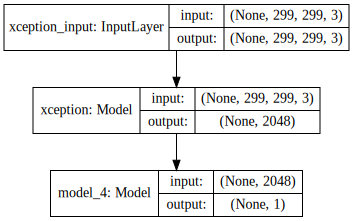

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
model_4 (Model)              (None, 1)                 524801    
Total params: 21,386,281
Trainable params: 5,275,649
Non-trainable params: 16,110,632
_________________________________________________________________


In [29]:
import numpy as np
from tqdm import tqdm

from keras.preprocessing import image
from sklearn.utils import shuffle

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2018)

n = 25000
n_test = 12500

X = np.zeros((n,299,299,3),dtype = np.uint8)
y = np.zeros((n,1),dtype = np.uint8)

X_test = np.zeros((n_test,299,299,3),dtype = np.uint8)

for i in tqdm(range(int(n/2))):
    X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg'%i),(299,299))
    X[i+int(n/2)] = cv2.resize(cv2.imread('train/dog.%d.jpg'%i),(299,299))

y[int(n/2):] = 1

X_train,y_train = shuffle(X,y)


100%|██████████| 12500/12500 [02:50<00:00, 73.12it/s]


In [30]:
from keras.callbacks import Callback,EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self,log={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
    def on_epoch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = LossHistory()

earlystop = EarlyStopping(monitor='val_acc',patience =10,verbose=1,mode = 'max')

model.fit(X_train, y_train, batch_size=128, epochs=50,validation_split=0.2,callbacks = [history,earlystop])

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 138s 7ms/step - loss: 0.1645 - acc: 0.9542 - val_loss: 0.0177 - val_acc: 0.9942
Epoch 2/50
20000/20000 [==============================] - 112s 6ms/step - loss: 0.1029 - acc: 0.9694 - val_loss: 0.0185 - val_acc: 0.9942
Epoch 3/50
20000/20000 [==============================] - 112s 6ms/step - loss: 0.0740 - acc: 0.9748 - val_loss: 0.0205 - val_acc: 0.9926
Epoch 4/50
20000/20000 [==============================] - 112s 6ms/step - loss: 0.0711 - acc: 0.9770 - val_loss: 0.0225 - val_acc: 0.9920
Epoch 5/50
20000/20000 [==============================] - 112s 6ms/step - loss: 0.0635 - acc: 0.9778 - val_loss: 0.0238 - val_acc: 0.9914
Epoch 6/50
20000/20000 [==============================] - 112s 6ms/step - loss: 0.0591 - acc: 0.9799 - val_loss: 0.0253 - val_acc: 0.9910
Epoch 7/50
20000/20000 [==============================] - 112s 6ms/step - loss: 0.0593 - acc: 0.9796 - val_loss: 0.0261 - v

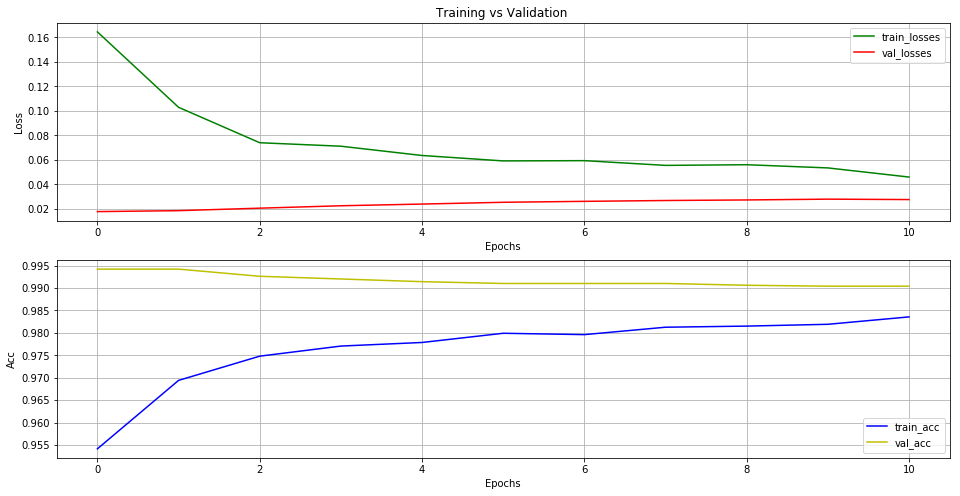

In [31]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

losses,val_losses ,acc,val_acc= history.losses,history.val_losses,history.acc,history.val_acc
fig = plt.figure(figsize = (16,8))

plt.subplot(211) 

plt.plot(losses,'g',label = 'train_losses')
plt.plot(val_losses,'r',label = 'val_losses')
plt.grid(True)
plt.title('Training vs Validation ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc=0)

plt.subplot(212) 

plt.plot(acc,'b',label = 'train_acc')
plt.plot(val_acc,'y',label = 'val_acc')
plt.ylabel('Acc')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(loc=0)

In [32]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

import os

df = pd.read_csv("sample_submission.csv")

image_size = (299, 299)
image_gen = ImageDataGenerator()
test_gen  = image_gen.flow_from_directory("test_gen",image_size, shuffle=False, batch_size=16, class_mode=None)

y_pred = model.predict_generator(test_gen,verbose = 1)
y_pred = y_pred.clip(min=0.005, max=0.995)


pred_filenames = test_gen.filenames

#pred_filenames = os.listdir('test_gen/test')

for i, fname in enumerate(pred_filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])


df.to_csv('pred_%s.csv'%'xception_fine', index=None)
df.head(10)



Found 12500 images belonging to 1 classes.
782/782 [==============================] - 70s 90ms/step


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


In [33]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

model_json_string = model.to_json()
open("./models/model_string_xception_fine.json",'w+').write(model_json_string)
model.save_weights("./models/model_weights_xception_fine.h5")

# Check point4

In [1]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

X_train = []
X_test = []
X_valid = []
#y_train = []

filenames = ['gap_pred_resnet50.h5','gap_pred_xception.h5','gap_pred_inception_v3.h5']

for filename in filenames:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        X_test.append(np.array(h['test']))
        y_train=np.array(h['train_label'])
        y_valid=np.array(h['valid_label'])


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)
X_valid = np.concatenate(X_valid,axis=1)

#X_train, y_train = shuffle(X_train, y_train)

In [3]:
print (np.shape(X_train),np.shape(y_train),np.shape(X_valid))

(20000, 6144) (20000,) (5000, 6144)


In [4]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5,name = 'dropout_top')(x)
x = Dense(1, activation='sigmoid',name = 'dense_top')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [5]:
from PIL import Image
from keras.preprocessing import image
from keras.callbacks import Callback,EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self,log={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
    def on_epoch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = LossHistory()
earlystop = EarlyStopping(monitor='val_acc',patience =10,verbose=1,mode = 'max')

In [6]:
model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data = (X_valid,y_valid),callbacks = [history,earlystop])

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 2s 86us/step - loss: 0.0718 - acc: 0.9759 - val_loss: 0.0243 - val_acc: 0.9908
Epoch 2/50
20000/20000 [==============================] - 1s 39us/step - loss: 0.0218 - acc: 0.9929 - val_loss: 0.0169 - val_acc: 0.9942
Epoch 3/50
20000/20000 [==============================] - 1s 39us/step - loss: 0.0174 - acc: 0.9946 - val_loss: 0.0153 - val_acc: 0.9946
Epoch 4/50
20000/20000 [==============================] - 1s 39us/step - loss: 0.0149 - acc: 0.9951 - val_loss: 0.0153 - val_acc: 0.9946
Epoch 5/50
20000/20000 [==============================] - 1s 39us/step - loss: 0.0145 - acc: 0.9950 - val_loss: 0.0148 - val_acc: 0.9944
Epoch 6/50
20000/20000 [==============================] - 1s 39us/step - loss: 0.0133 - acc: 0.9953 - val_loss: 0.0148 - val_acc: 0.9950
Epoch 7/50
20000/20000 [==============================] - 1s 38us/step - loss: 0.0114 - acc: 0.9967 - val_loss: 0.0156 - val_acc:

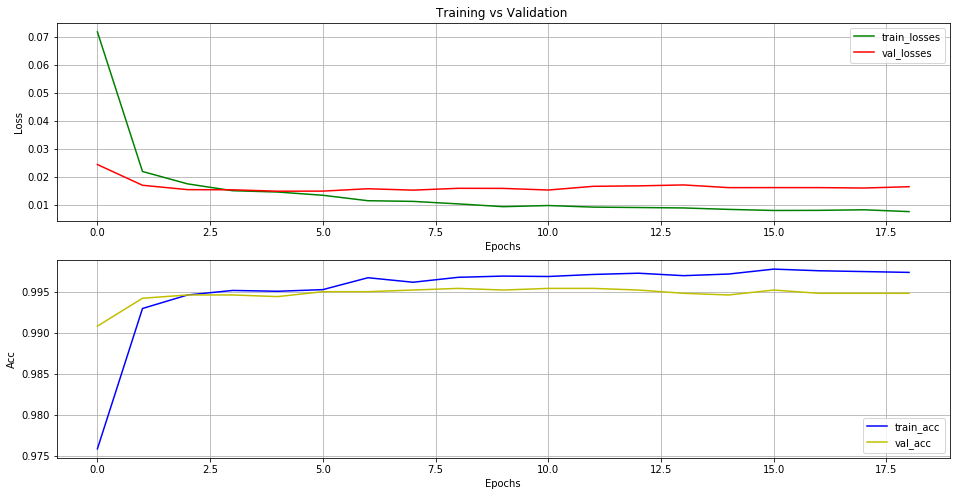

In [7]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

losses,val_losses ,acc,val_acc= history.losses,history.val_losses,history.acc,history.val_acc
fig = plt.figure(figsize = (16,8))

plt.subplot(211) 

plt.plot(losses,'g',label = 'train_losses')
plt.plot(val_losses,'r',label = 'val_losses')
plt.grid(True)
plt.title('Training vs Validation ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc=0)

plt.subplot(212) 

plt.plot(acc,'b',label = 'train_acc')
plt.plot(val_acc,'y',label = 'val_acc')
plt.ylabel('Acc')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(loc=0)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6144)              0         
_________________________________________________________________
dropout_top (Dropout)        (None, 6144)              0         
_________________________________________________________________
dense_top (Dense)            (None, 1)                 6145      
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


In [10]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

import os

df = pd.read_csv("sample_submission.csv")

image_size = (299, 299)
image_gen = ImageDataGenerator()
test_gen  = image_gen.flow_from_directory("test_gen",image_size, shuffle=False, batch_size=16, class_mode=None)

#y_pred = model.predict_generator(test_gen,verbose = 1)
y_pred = model.predict(X_test,verbose = 1)
y_pred = y_pred.clip(min=0.005, max=0.995)


pred_filenames = test_gen.filenames

#pred_filenames = os.listdir('test_gen/test')

for i, fname in enumerate(pred_filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])


df.to_csv('pred_gap.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.
12500/12500 [==============================] - 0s 35us/step


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


In [12]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

model_json_string = model.to_json()
open("./models/model_string_xception_fine.json",'w+').write(model_json_string)
model.save_weights("./models/model_weights_gap_top.h5")

In [43]:
from keras.models import Model,Sequential,model_from_json
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,Input,Lambda,Concatenate
from keras.applications.xception import Xception,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import xception,inception_v3



gap_resnet50 = ResNet50(weights = 'imagenet',include_top = False,pooling = 'avg')

gap_xception = Xception(weights = 'imagenet',include_top = False,pooling = 'avg')

gap_inceptionv3 = InceptionV3(weights = 'imagenet',include_top = False,pooling = 'avg')

input_1 = Input((224,224,3),name = 'input_224')

input_2 = Input((299,299,3),name = 'input_299')
x_xception = Lambda(xception.preprocess_input)(input_2)
x_inceptionv3 = Lambda(inception_v3.preprocess_input)(input_2)

gap_resnet50 = gap_resnet50(input_1)

gap_xception = gap_xception(x_xception)

gap_inceptionv3 = gap_inceptionv3(x_inceptionv3)


In [44]:
layer = Concatenate(axis = 1)([gap_resnet50,gap_xception,gap_inceptionv3])

layer = Dropout(0.5,name = 'dropout_top')(layer)
layer = Dense(1, activation='sigmoid',name = 'dense_top')(layer)
model = Model([input_1,input_2],layer)


model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
model.load_weights('./models/model_weights_gap_top.h5',by_name= True)
for layer in model.layers:
    layer.trainable = False

In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_299 (InputLayer)          (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_224 (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 299, 299, 3)  0           input_299[0][0]                  
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 299, 299, 3)  0           input_299[0][0]                  
__________________________________________________________________________________________________
resnet50 (

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


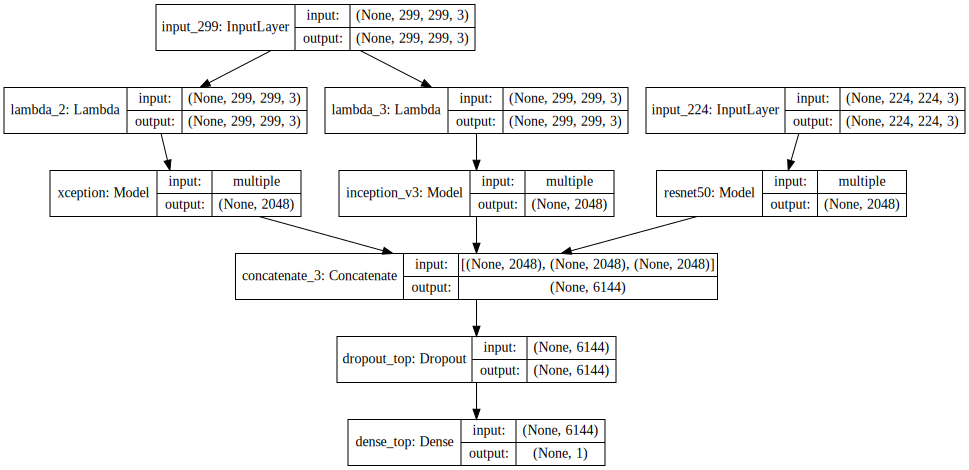

In [50]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))